In [9]:
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import copy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
STOP_WORDS_EN = set(stopwords.words('english'))
STEMMER = SnowballStemmer('romanian')
MAX_LEN = 32

WORD_TO_INDEX = {}
WORD_TO_INDEX["<mask>"] = 0 
WORD_TO_INDEX["<pad>"] = 1
WORD_TO_INDEX["<unk>"] = 2

def get_tokens(caption):
    caption = caption.lower()
    
    caption = re.sub(r'[^\w\s]', ' ', caption)
    caption = re.sub(r'\s+', ' ', caption)
    caption = word_tokenize(caption)
    
    tokens = []
    for word in caption:
        if word not in STOP_WORDS_EN:
            stemmed_word = STEMMER.stem(word)
            tokens.append(stemmed_word)
    
    return tokens

def build_vocab(tokenized_captions):
    global WORD_TO_INDEX
    vocab = Counter(word for sent in tokenized_captions for word in sent)
    for id, (word, _) in enumerate(vocab.items()):
        if word not in WORD_TO_INDEX:
            WORD_TO_INDEX[word] = id+3

class CaptionsDataset(Dataset):
    def __init__(self, root, split):
        global WORD_TO_INDEX
        csv_file = pd.read_csv(os.path.join(root, f"{split}.csv"))
        self.split = split

        captions = csv_file["caption"].to_numpy()
        
        tokenized_captions = []
        for caption in captions:
            tokenized_captions.append(get_tokens(caption))

        build_vocab(tokenized_captions)
        
        encoded_captions = []
        masked_captions = []
        self.labels = []
        for tokenized_caption in tokenized_captions:
            encoded_caption = []
            for token in tokenized_caption:
                if token in WORD_TO_INDEX:
                    encoded_caption.append(WORD_TO_INDEX[token])
                else:
                    encoded_caption.append(WORD_TO_INDEX["<unk>"])

            encoded_captions.append(encoded_caption)

            mask_idx = np.random.randint(len(encoded_caption))
            masked_caption = copy.deepcopy(encoded_caption)
            masked_caption[mask_idx] = WORD_TO_INDEX["<mask>"]

            self.labels.append(encoded_caption[mask_idx])
            masked_captions.append(masked_caption)
        
        encoded_captions_padded = []
        masked_captions_padded = []
        for encoded_caption, masked_caption in zip(encoded_captions, masked_captions):
            num_pads = MAX_LEN - len(encoded_caption)
            encoded_captions_padded.append(encoded_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)
            masked_captions_padded.append(masked_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)

        self.data = [encoded_captions_padded, masked_captions_padded]

    def __len__(self):
        return len(self.data[0])
        
    def __getitem__(self, idx):
        sample = self.data[0][idx]
        sample = torch.tensor(sample).int()

        masked_sample = self.data[1][idx]
        masked_sample = torch.tensor(masked_sample).int()

        label = self.labels[idx]
        
        return masked_sample, label

In [12]:
class LanguageModel(nn.Module):
    def __init__(self, params):
        super(LanguageModel, self).__init__()
        if len(params) > 0:
            vocab_size = params["vocab_size"]
            embed_dim = params["embed_dim"]
            hidden_dim = params["hidden_dim"]
            num_layers = params["num_layers"]
            
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden_state, _) = self.lstm(x)
        out = self.linear(hidden_state[-1])
        return out

In [13]:
batch_size = 64
lr = 1e-3
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

root = "/kaggle/input/image-sentence-pair-matching"

train_dataset = CaptionsDataset(root, "train")
val_dataset = CaptionsDataset(root, "val")
test_dataset = CaptionsDataset(root, "test")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

params = {
    "vocab_size": len(WORD_TO_INDEX), 
    "embed_dim": 256,
    "hidden_dim": 512,
    "num_layers": 1
}

In [15]:
def train_step(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    for txt_inputs, labels in tqdm(train_loader):
        txt_inputs, labels = txt_inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(txt_inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(predictions == labels).item()
        total_preds += labels.shape[0]

    train_step_loss = total_loss / len(train_loader)
    train_step_acc = correct_preds / total_preds

    return train_step_loss, train_step_acc

def val_step(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    with torch.no_grad():
        for txt_inputs, labels in tqdm(val_loader):
            txt_inputs, labels = txt_inputs.to(device), labels.to(device)

            outputs = model(txt_inputs)
            loss = loss_fn(outputs, labels)
    
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(predictions == labels).item()
            total_preds += labels.shape[0]

    val_step_loss = total_loss / len(val_loader)
    val_step_acc = correct_preds / total_preds

    return val_step_loss, val_step_acc

def train():
    model = LanguageModel(params).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0.0

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_step_loss, train_step_acc = train_step(model, train_dataloader, optimizer, loss_fn)
        print(f"train_step_loss: {train_step_loss} | train_step_acc = {train_step_acc}")
        
        val_step_loss, val_step_acc = val_step(model, val_dataloader, loss_fn)
        print(f"val_step_loss: {val_step_loss} | val_step_acc = {val_step_acc}")

        train_losses.append(train_step_loss)
        train_accs.append(train_step_acc)
        val_losses.append(val_step_loss)
        val_accs.append(val_step_acc)

        if val_step_acc > best_acc:
            best_acc = val_step_acc
            torch.save(model.state_dict(), "language_model.pt")

    plt.plot(range(epochs), train_losses)
    plt.title("Train loss")
    plt.savefig("train_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), train_accs)
    plt.title("Train acc")
    plt.savefig("train_acc.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_losses)
    plt.title("Val loss")
    plt.savefig("val_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_accs)
    plt.title("Val acc")
    plt.savefig("val_acc.jpg")
    plt.plot()

epoch: 1


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.929817272599336 | train_step_acc = 0.0152


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.75945317491572 | val_step_acc = 0.009666666666666667
epoch: 2


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.515170206689531 | train_step_acc = 0.0173


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.807463848844487 | val_step_acc = 0.012333333333333333
epoch: 3


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.483331063750443 | train_step_acc = 0.0161


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.85791484345781 | val_step_acc = 0.01633333333333333
epoch: 4


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.476685545247072 | train_step_acc = 0.0164


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.871183608440643 | val_step_acc = 0.01633333333333333
epoch: 5


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.472578668290643 | train_step_acc = 0.0182


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.882823589000296 | val_step_acc = 0.01633333333333333
epoch: 6


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.463373251022047 | train_step_acc = 0.0182


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.9190418669518 | val_step_acc = 0.01633333333333333
epoch: 7


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.473149794681817 | train_step_acc = 0.0185


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.8681997441230935 | val_step_acc = 0.017666666666666667
epoch: 8


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.382549273739954 | train_step_acc = 0.0218


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.728407646747345 | val_step_acc = 0.027
epoch: 9


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.185507230697923 | train_step_acc = 0.0293


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.630328990043478 | val_step_acc = 0.030666666666666665
epoch: 10


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.985405032042485 | train_step_acc = 0.0464


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.523167569586572 | val_step_acc = 0.03833333333333333
epoch: 11


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.736399425822459 | train_step_acc = 0.0673


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.3783734402758006 | val_step_acc = 0.050666666666666665
epoch: 12


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.461957843440353 | train_step_acc = 0.0783


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.309617661415262 | val_step_acc = 0.06166666666666667
epoch: 13


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.195987710527554 | train_step_acc = 0.096


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.2554450035095215 | val_step_acc = 0.071
epoch: 14


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.901813391667263 | train_step_acc = 0.1257


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.194462877638797 | val_step_acc = 0.084
epoch: 15


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.618362479908451 | train_step_acc = 0.151


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.204737622687158 | val_step_acc = 0.10233333333333333
epoch: 16


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.31720851333278 | train_step_acc = 0.1886


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.214017979642178 | val_step_acc = 0.11966666666666667
epoch: 17


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.016900237198848 | train_step_acc = 0.2287


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.258516585573237 | val_step_acc = 0.12633333333333333
epoch: 18


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.7333125081031944 | train_step_acc = 0.2704


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.298690724880137 | val_step_acc = 0.14166666666666666
epoch: 19


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.4215465973896584 | train_step_acc = 0.3242


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.4051670825227776 | val_step_acc = 0.136
epoch: 20


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.0925069234933065 | train_step_acc = 0.3749


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.484546397594696 | val_step_acc = 0.15666666666666668
epoch: 21


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.757518128984293 | train_step_acc = 0.4265


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.526352740348654 | val_step_acc = 0.17666666666666667
epoch: 22


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.4062910452010526 | train_step_acc = 0.4897


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.599913302888262 | val_step_acc = 0.185
epoch: 23


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.0605513419315313 | train_step_acc = 0.5535


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.849888943611307 | val_step_acc = 0.20666666666666667
epoch: 24


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.7439772809387013 | train_step_acc = 0.6173


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.922949222808189 | val_step_acc = 0.22133333333333333
epoch: 25


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.443229262236577 | train_step_acc = 0.6919


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.074171482248509 | val_step_acc = 0.23233333333333334
epoch: 26


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.1540977438544011 | train_step_acc = 0.7564


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.266316210969966 | val_step_acc = 0.25
epoch: 27


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.9033289730169212 | train_step_acc = 0.8201


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.483085794651762 | val_step_acc = 0.267
epoch: 28


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.7016104903950053 | train_step_acc = 0.8669


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.651786986817705 | val_step_acc = 0.273
epoch: 29


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.5194884884129664 | train_step_acc = 0.9086


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.703701333796724 | val_step_acc = 0.277
epoch: 30


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.36591955098756557 | train_step_acc = 0.9459


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.932673342684482 | val_step_acc = 0.284
epoch: 31


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.2690065516408082 | train_step_acc = 0.964


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.031145319025567 | val_step_acc = 0.2866666666666667
epoch: 32


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.1941590814548693 | train_step_acc = 0.9752


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.176885533840098 | val_step_acc = 0.2843333333333333
epoch: 33


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.1545689994362509 | train_step_acc = 0.9827


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.298369438090223 | val_step_acc = 0.29233333333333333
epoch: 34


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.10204337803041859 | train_step_acc = 0.989


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.427405042851225 | val_step_acc = 0.293
epoch: 35


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.07405888258366827 | train_step_acc = 0.9923


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.552418323273354 | val_step_acc = 0.29233333333333333
epoch: 36


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.05355705770480025 | train_step_acc = 0.9935


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.659350374911694 | val_step_acc = 0.296
epoch: 37


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.03995584212480836 | train_step_acc = 0.9944


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.68298927266547 | val_step_acc = 0.29733333333333334
epoch: 38


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.03239108646988489 | train_step_acc = 0.9949


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.773784383814386 | val_step_acc = 0.296
epoch: 39


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.025153434503182862 | train_step_acc = 0.996


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.854603828267848 | val_step_acc = 0.29433333333333334
epoch: 40


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.026582505992928128 | train_step_acc = 0.9952


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.906396074497954 | val_step_acc = 0.296
epoch: 41


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.029722320254014178 | train_step_acc = 0.9948


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.971309945938435 | val_step_acc = 0.2966666666666667
epoch: 42


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.030062330868925638 | train_step_acc = 0.9939


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.962660150325044 | val_step_acc = 0.2896666666666667
epoch: 43


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0569871151938465 | train_step_acc = 0.9898


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.880625988574739 | val_step_acc = 0.28633333333333333
epoch: 44


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.5059404711055148 | train_step_acc = 0.8797


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.448912285743877 | val_step_acc = 0.256
epoch: 45


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.5864139613072583 | train_step_acc = 0.8595


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.379401978026046 | val_step_acc = 0.293
epoch: 46


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.22984081824683839 | train_step_acc = 0.9489


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.579585460906333 | val_step_acc = 0.2946666666666667
epoch: 47


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0860200643325877 | train_step_acc = 0.9872


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.744335347033562 | val_step_acc = 0.2926666666666667
epoch: 48


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.04468359753109847 | train_step_acc = 0.9928


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.897338299041099 | val_step_acc = 0.295
epoch: 49


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.026040144703665356 | train_step_acc = 0.9952


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.99506999076681 | val_step_acc = 0.29733333333333334
epoch: 50


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.02088444402654934 | train_step_acc = 0.9949


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 9.070409257361229 | val_step_acc = 0.299


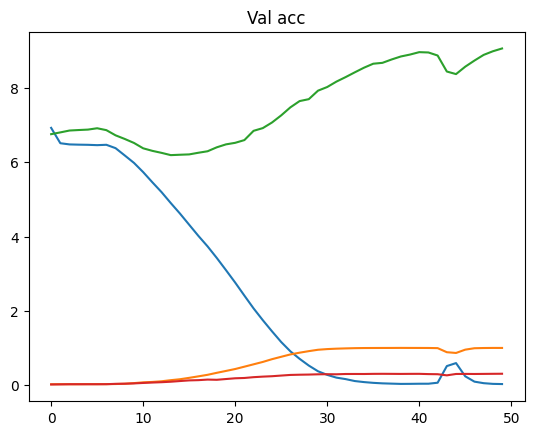

In [16]:
train()